In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import pandas as pd
import boto3
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("whitegrid")

## Importamos la información

In [4]:
session = boto3.session.Session()
s3client = session.client('s3')

In [5]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles/df.pkl')

body = response['Body'].read()
df = pickle.loads(body)

In [6]:
df.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,sector,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real,solicitud_longitud,descripcionsolicitud_lemma,codigo_calidad_respuesta_real
0,1857500001912,2012-01-01 05:04:07,pemex exploracion y produccion,terminada,electronica,informacion publica,copia de los documentos y los con que cuenta a...,None,None,entrega por internet en el infomex,...,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 02...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,768,copiar documento comportamiento historico tipi...,0
1,1857500002012,2012-01-01 05:13:16,pemex exploracion y produccion,terminada,electronica,informacion publica,del informacion y usados en la de flujo de efe...,None,None,entrega por internet en el infomex,...,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 01...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,548,informacion usar flujo efectivo pozo tipico ag...,0
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,energia,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida,269,proporcionar magnetico relacion ocupar amparar...,1
3,0000600003712,2012-01-01 10:11:41,secretaria de hacienda y credito publico,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,hacienda y credito publico,pdf,1.0,inidos secretaria de hacienda y credito public...,la informacion esta disponible publicamente,satisfactoria,satisfactoria,269,proporcionar magnetico relacion ocupar amparar...,0
4,0001500002812,2012-01-01 10:32:15,secretaria de desarrollo agrario territorial y...,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,reforma agraria,zip,4.0,None,sin respuesta,satisfactoria,no respondida,398,proporcionar magnetico relacion ocupar amparar...,1


## Implementación LDA

Quitamos palabras identificadas en el primer analisis LDA validadas con SocialTIC.

In [7]:
banned = ['federativo', 'materia', 'activar', 'cargar', 'transparencia', 'poblacion', 'favor', 
          'directo', 'fecho', 'registrar', 'emplear', 'campar', 'atencion',
          'pagar', 'reportar', 'publicos', 'encontrar', 'entidad',
          'acceso', 'derecho', 'concepto', 'recurso', 'beneficiario', 'esperar', 'expedientar', 'basar',
          'documento', 'presentar', 'clavar', 'personal', 'solucion', 'adjuntar', 'adjunto',
          'respuesta','solicitud','solicitar', 'solicito', 'solicitamos', 'solicite', 'informacion', 'mexico', 
          'titular', 'copiar', 'copie', 'copiamos', 'dependencia', 'contratar', 
          'contrato', 'servicio', 'proyectar', 'proyectamos', 'proyecte', 'proyeccion', 
          'nacional', 'administrativo', 'correo', 'programar', 'programa',
          'programacion', 'personar', 'edad', 'unidad', 'circuito']

In [8]:
f = lambda x: ' '.join([item for item in x.split() if item not in banned])
df['descripcionsolicitud_lemma'] = df['descripcionsolicitud_lemma'].apply(f)

In [9]:
df['solicitud_lemma_longitud'] = df['descripcionsolicitud_lemma'].str.len()

In [10]:
df.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real,solicitud_longitud,descripcionsolicitud_lemma,codigo_calidad_respuesta_real,solicitud_lemma_longitud
0,1857500001912,2012-01-01 05:04:07,pemex exploracion y produccion,terminada,electronica,informacion publica,copia de los documentos y los con que cuenta a...,None,None,entrega por internet en el infomex,...,pdf,1.0,pemex exploracion y produccion oficio fecha 02...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,768,comportamiento historico tipicos comprender es...,0,424
1,1857500002012,2012-01-01 05:13:16,pemex exploracion y produccion,terminada,electronica,informacion publica,del informacion y usados en la de flujo de efe...,None,None,entrega por internet en el infomex,...,pdf,1.0,pemex exploracion y produccion oficio fecha 01...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,548,usar flujo efectivo pozo tipico aguar fria ela...,0,289
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida,269,proporcionar magnetico relacion ocupar amparar...,1,143
3,0000600003712,2012-01-01 10:11:41,secretaria de hacienda y credito publico,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,pdf,1.0,inidos secretaria de hacienda y credito public...,la informacion esta disponible publicamente,satisfactoria,satisfactoria,269,proporcionar magnetico relacion ocupar amparar...,0,143
4,0001500002812,2012-01-01 10:32:15,secretaria de desarrollo agrario territorial y...,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,zip,4.0,None,sin respuesta,satisfactoria,no respondida,398,proporcionar magnetico relacion ocupar amparar...,1,188


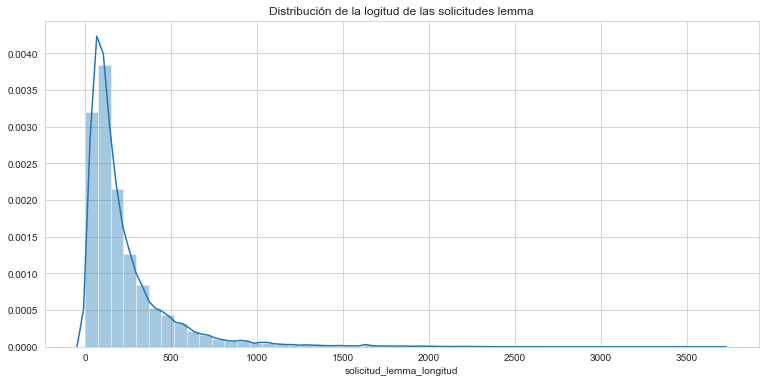

In [11]:
plt.figure(figsize=(12.8, 6))
sns.distplot(df['solicitud_lemma_longitud']).set_title('Distribución de la logitud de las solicitudes lemma');

In [12]:
df['solicitud_lemma_longitud'].describe()

count    1.171697e+06
mean     2.267662e+02
std      2.603016e+02
min      0.000000e+00
25%      7.700000e+01
50%      1.410000e+02
75%      2.740000e+02
max      3.681000e+03
Name: solicitud_lemma_longitud, dtype: float64

In [13]:
filtro = df['solicitud_lemma_longitud'] < 16
cases = df[filtro]

In [14]:
len(cases)

29686

In [15]:
df_new = df[df['descripcionsolicitud_lemma'].map(len) > 15]

In [16]:
df_new['solicitud_lemma_longitud'].describe()

count    1.142011e+06
mean     2.324750e+02
std      2.612111e+02
min      1.600000e+01
25%      8.100000e+01
50%      1.450000e+02
75%      2.800000e+02
max      3.681000e+03
Name: solicitud_lemma_longitud, dtype: float64

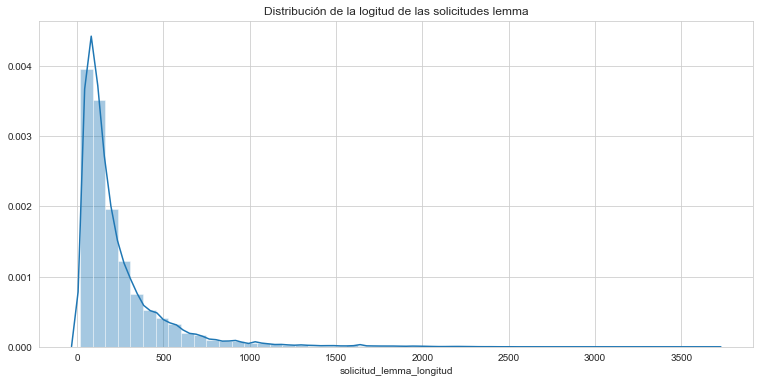

In [17]:
plt.figure(figsize=(12.8, 6))
sns.distplot(df_new['solicitud_lemma_longitud']).set_title('Distribución de la logitud de las solicitudes lemma');

In [18]:
data = df_new[['descripcionsolicitud_lemma']]
data['index'] = data.index
docs = data

In [19]:
docs.head()

,descripcionsolicitud_lemma,index
0,comportamiento historico tipicos comprender es...,0
1,usar flujo efectivo pozo tipico aguar fria ela...,1
2,proporcionar magnetico relacion ocupar amparar...,2
3,proporcionar magnetico relacion ocupar amparar...,3
4,proporcionar magnetico relacion ocupar amparar...,4


In [20]:
import spacy
import nltk
from nltk import SnowballStemmer

In [21]:
nlp = spacy.load('es_core_news_sm')

In [22]:
def ProcesarTexto(texto):
    
    doc = nlp(texto)
    words = [t.text for t in doc]
    
    return words

In [23]:
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

In [24]:
cores = multiprocessing.cpu_count()
pool = ThreadPool(cores)
cores

12

In [25]:
processed_docs = pool.map(ProcesarTexto, docs['descripcionsolicitud_lemma'])
pool.close()

In [26]:
import gensim

In [27]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [28]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [29]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [30]:
from gensim import corpora, models
from pprint import pprint

In [31]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

## 5 tópicos TF-IDF

In [32]:
lda_model_tfidf_5 = gensim.models.LdaMulticore(corpus_tfidf, 
                                            num_topics=5,
                                            id2word=dictionary,
                                            passes=2,
                                            workers=cores)

In [33]:
for idx, topic in lda_model_tfidf_5.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.004*"montar" + 0.004*"federal" + 0.004*"concesion" + 0.003*"presupuestar" + 0.003*"desglosar" + 0.003*"partir" + 0.003*"publicar" + 0.003*"municipio" + 0.003*"informar" + 0.003*"federacion"
Topic: 1 Word: 0.011*"sanitario" + 0.008*"tramitar" + 0.006*"amparar" + 0.006*"cofepris" + 0.006*"tribunal" + 0.006*"federal" + 0.005*"comision" + 0.005*"juicio" + 0.004*"colegiar" + 0.004*"permiso"
Topic: 2 Word: 0.006*"servidor" + 0.004*"publicar" + 0.004*"secretario" + 0.004*"laborar" + 0.003*"director" + 0.003*"informar" + 0.003*"soldar" + 0.003*"requerir" + 0.003*"casar" + 0.003*"profesional"
Topic: 3 Word: 0.021*"medicamento" + 0.017*"medicar" + 0.011*"licitacion" + 0.008*"adquirir" + 0.008*"hospital" + 0.008*"adjudicacion" + 0.007*"recetar" + 0.007*"paciente" + 0.007*"proveedor" + 0.007*"articular"
Topic: 4 Word: 0.006*"presupuestar" + 0.006*"trabajador" + 0.006*"municipio" + 0.006*"educacion" + 0.004*"desglosar" + 0.004*"escuela" + 0.004*"nivel" + 0.004*"seguro" + 0.004*"del

In [34]:
texto = docs[docs['index'] == 4310].values[0][0]
texto

'institucion explicar procedimiento instalar cafeterias plantel maquinar cafe refresco producto industrializar convenio formalizar instalacion citar centro ganancia institucion plantel dejar consentir talar formar mercantil negociar autoridad consentimiento destinar'

In [35]:
for index, score in sorted(lda_model_tfidf_5[bow_corpus[4310]],
                          key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}.".format(score,
                                             lda_model_tfidf_5.print_topic(index, 5)))


Score: 0.863035261631012	 
Topic: 0.004*"montar" + 0.004*"federal" + 0.004*"concesion" + 0.003*"presupuestar" + 0.003*"desglosar".

Score: 0.0347917340695858	 
Topic: 0.006*"presupuestar" + 0.006*"trabajador" + 0.006*"municipio" + 0.006*"educacion" + 0.004*"desglosar".

Score: 0.03406837582588196	 
Topic: 0.006*"servidor" + 0.004*"publicar" + 0.004*"secretario" + 0.004*"laborar" + 0.003*"director".

Score: 0.03406349942088127	 
Topic: 0.021*"medicamento" + 0.017*"medicar" + 0.011*"licitacion" + 0.008*"adquirir" + 0.008*"hospital".

Score: 0.03404110297560692	 
Topic: 0.011*"sanitario" + 0.008*"tramitar" + 0.006*"amparar" + 0.006*"cofepris" + 0.006*"tribunal".


## 10 tópicos TF-IDF

In [36]:
lda_model_tfidf_10 = gensim.models.LdaMulticore(corpus_tfidf, 
                                            num_topics=10,
                                            id2word=dictionary,
                                            passes=2,
                                            workers=cores)

In [37]:
for idx, topic in lda_model_tfidf_10.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.007*"trabajador" + 0.006*"laborar" + 0.005*"montar" + 0.005*"sindicato" + 0.005*"secretario" + 0.005*"mensual" + 0.005*"salariar" + 0.004*"informar" + 0.004*"director" + 0.004*"diputar"
Topic: 1 Word: 0.013*"licitacion" + 0.010*"empresa" + 0.008*"adquisicion" + 0.007*"anexo" + 0.007*"acta" + 0.007*"procedimiento" + 0.007*"contratacion" + 0.007*"condonar" + 0.006*"montar" + 0.006*"convenio"
Topic: 2 Word: 0.008*"padron" + 0.008*"municipio" + 0.008*"tipo" + 0.006*"desglosar" + 0.006*"montar" + 0.006*"servidor" + 0.005*"delito" + 0.005*"publicar" + 0.005*"periodo" + 0.004*"sociedad"
Topic: 3 Word: 0.011*"tribunal" + 0.011*"amparar" + 0.009*"juicio" + 0.009*"colegiar" + 0.006*"dictar" + 0.006*"federal" + 0.006*"distrito" + 0.005*"penal" + 0.005*"resolucion" + 0.005*"servidor"
Topic: 4 Word: 0.035*"sanitario" + 0.021*"cofepris" + 0.021*"tramitar" + 0.010*"comision" + 0.009*"ingresar" + 0.008*"registro" + 0.008*"sustanciar" + 0.008*"evidenciar" + 0.008*"consignar" + 0.007*"d

In [38]:
texto = docs[docs['index'] == 4310].values[0][0]
texto

'institucion explicar procedimiento instalar cafeterias plantel maquinar cafe refresco producto industrializar convenio formalizar instalacion citar centro ganancia institucion plantel dejar consentir talar formar mercantil negociar autoridad consentimiento destinar'

In [39]:
for index, score in sorted(lda_model_tfidf_10[bow_corpus[4310]],
                          key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}.".format(score,
                                             lda_model_tfidf_10.print_topic(index, 10)))


Score: 0.8499323129653931	 
Topic: 0.008*"padron" + 0.008*"municipio" + 0.008*"tipo" + 0.006*"desglosar" + 0.006*"montar" + 0.006*"servidor" + 0.005*"delito" + 0.005*"publicar" + 0.005*"periodo" + 0.004*"sociedad".

Score: 0.016679689288139343	 
Topic: 0.006*"documentar" + 0.006*"articular" + 0.005*"publicar" + 0.005*"fundamentar" + 0.005*"proporcionar" + 0.004*"direccion" + 0.004*"oficiar" + 0.004*"salud" + 0.004*"secretario" + 0.004*"consejo".

Score: 0.016674766317009926	 
Topic: 0.012*"presupuestar" + 0.009*"seguro" + 0.007*"instituto" + 0.007*"salud" + 0.006*"hospital" + 0.006*"medicos" + 0.006*"imss" + 0.006*"social" + 0.005*"medicar" + 0.005*"pensionar".

Score: 0.016674641519784927	 
Topic: 0.039*"medicamento" + 0.032*"medicar" + 0.016*"recetar" + 0.015*"paciente" + 0.014*"hospital" + 0.013*"pieza" + 0.011*"basico" + 0.011*"cuadrar" + 0.008*"facturar" + 0.007*"nivel".

Score: 0.016674481332302094	 
Topic: 0.005*"gracia" + 0.005*"quedar" + 0.005*"valioso" + 0.005*"municipio" + 

## 20 tópicos TF-IDF

In [40]:
lda_model_tfidf_20 = gensim.models.LdaMulticore(corpus_tfidf, 
                                            num_topics=20,
                                            id2word=dictionary,
                                            passes=2,
                                            workers=cores)

In [41]:
for idx, topic in lda_model_tfidf_20.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.009*"sociedad" + 0.008*"montar" + 0.008*"periodo" + 0.007*"prestador" + 0.007*"premio" + 0.007*"aplicar" + 0.007*"tipo" + 0.006*"comprender" + 0.006*"essa" + 0.005*"cepillo"
Topic: 1 Word: 0.010*"delito" + 0.007*"mujer" + 0.005*"desglosar" + 0.005*"victimar" + 0.005*"denunciar" + 0.005*"violencia" + 0.005*"federal" + 0.005*"caso" + 0.004*"tipo" + 0.004*"discapacidad"
Topic: 2 Word: 0.011*"informatica" + 0.009*"montar" + 0.009*"adquisicion" + 0.009*"bien" + 0.008*"inmueble" + 0.008*"rentar" + 0.007*"preguntar" + 0.007*"empresa" + 0.007*"dentilab" + 0.006*"proveedor"
Topic: 3 Word: 0.010*"investigacion" + 0.009*"protocolar" + 0.006*"fumigacion" + 0.005*"control" + 0.005*"curso" + 0.005*"informar" + 0.004*"capacitacion" + 0.004*"desechar" + 0.004*"protocolo" + 0.004*"aprobar"
Topic: 4 Word: 0.016*"electoral" + 0.013*"partir" + 0.007*"politico" + 0.006*"candidato" + 0.005*"politicos" + 0.005*"electronicas" + 0.005*"digital" + 0.005*"facturar" + 0.005*"elección" + 0.004*"co

In [42]:
texto = docs[docs['index'] == 4310].values[0][0]
texto

'institucion explicar procedimiento instalar cafeterias plantel maquinar cafe refresco producto industrializar convenio formalizar instalacion citar centro ganancia institucion plantel dejar consentir talar formar mercantil negociar autoridad consentimiento destinar'

In [43]:
for index, score in sorted(lda_model_tfidf_20[bow_corpus[4310]],
                          key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}.".format(score,
                                             lda_model_tfidf_20.print_topic(index, 20)))


Score: 0.8416386246681213	 
Topic: 0.010*"delito" + 0.007*"mujer" + 0.005*"desglosar" + 0.005*"victimar" + 0.005*"denunciar" + 0.005*"violencia" + 0.005*"federal" + 0.005*"caso" + 0.004*"tipo" + 0.004*"discapacidad" + 0.004*"elemento" + 0.004*"informar" + 0.004*"municipio" + 0.004*"detenido" + 0.004*"migrante" + 0.003*"generar" + 0.003*"atender" + 0.003*"robar" + 0.003*"penal" + 0.003*"periodo".


## Guardamos en S3

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/2/df.pkl'
pickle_byte_obj = pickle.dumps(df_new)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/2/processed_docs.pkl'
pickle_byte_obj = pickle.dumps(processed_docs)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/2/lda_model_tfidf_5.pkl'
pickle_byte_obj = pickle.dumps(lda_model_tfidf_5)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/2/lda_model_tfidf_10.pkl'
pickle_byte_obj = pickle.dumps(lda_model_tfidf_10)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/2/lda_model_tfidf_20.pkl'
pickle_byte_obj = pickle.dumps(lda_model_tfidf_20)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)